In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns

#Libraries for preprocessing
from gensim.parsing.preprocessing import remove_stopwords
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import webcolors

#Download once if using NLTK for preprocessing
import nltk

#Libraries for vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from fuzzywuzzy import fuzz

#Libraries for clustering
from sklearn.cluster import KMeans

In [74]:
df = pd.read_csv("../data/survey.csv")
df["industry"].fillna("Prefer not to answer", inplace=True)
df.drop("Unnamed: 0", axis=1, inplace=True)

# Preprocessing

In [3]:
text1 = df['industry']

## Removing stopwords, punctuation and numbers

In [4]:
text2 = [remove_stopwords(x)\
        .translate(str.maketrans('','',string.punctuation))\
        .translate(str.maketrans('','',string.digits))\
        for x in text1]

## Stemming and making words lower case

In [5]:
def stemSentence(sentence):
    porter = PorterStemmer()
    token_words = word_tokenize(sentence)
    stem_sentence = [porter.stem(word) for word in token_words]
    return ' '.join(stem_sentence)

In [6]:
text3 = pd.Series([stemSentence(x) for x in text2])

# TF IDF 2 grams

In [8]:
vectorizer_wtf = TfidfVectorizer(analyzer='word', ngram_range=(1,2))
X_wtf = vectorizer_wtf.fit_transform(text3)
matrix = pd.concat([text1, pd.DataFrame(X_wtf.toarray(), columns=vectorizer_wtf.get_feature_names_out())], axis=1)
matrix

,industry,academ,academ medicin,academ press,academ publish,academ research,academ scienc,academ scientif,academ technic,academia,...,world evid,worth,write,write journal,year,year old,yout,yout care,zoo,zoo aquarium
0,Education (Higher Education),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Computing or Tech,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Accounting, Banking & Finance",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Nonprofits,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Accounting, Banking & Finance",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26227,Media & Digital,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26228,Nonprofits,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26229,Computing or Tech,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26230,"Marketing, Advertising & PR",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


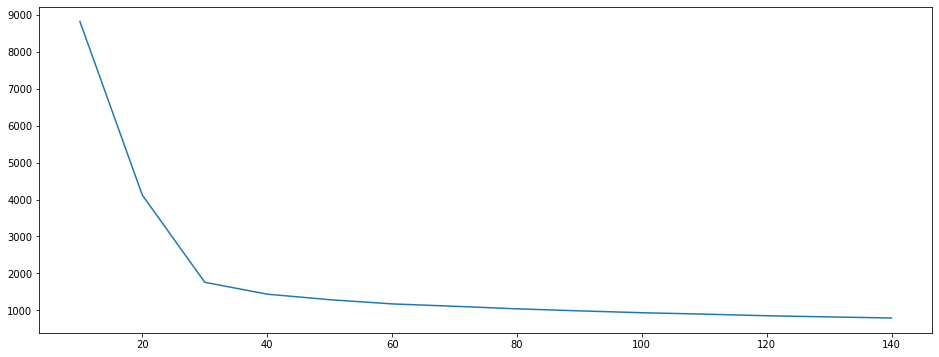

In [58]:
sse={}
for k in np.arange(10,150,10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_wtf)
    sse[k] = kmeans.inertia_

plt.figure(figsize=(16, 6))
plt.plot(list(sse.keys()),list(sse.values()))
plt.show()

In [10]:
kmeans = KMeans(n_clusters=50)
kmeans.fit(X_wtf)
result = pd.concat([text1,pd.DataFrame(X_wtf.toarray(),columns=vectorizer_wtf.get_feature_names_out())],axis=1)
result['cluster'] = kmeans.predict(X_wtf)
result[["industry", "cluster"]], kmeans.inertia_

(                            industry  cluster
 0       Education (Higher Education)        1
 1                  Computing or Tech        4
 2      Accounting, Banking & Finance        8
 3                         Nonprofits        3
 4      Accounting, Banking & Finance        8
 ...                              ...      ...
 26227                Media & Digital       16
 26228                     Nonprofits        3
 26229              Computing or Tech        4
 26230    Marketing, Advertising & PR        7
 26231                            Law        6
 
 [26232 rows x 2 columns],
 1283.9037333301874)

In [11]:
clusters = result['cluster'].unique()
labels = []
for i in range(len(clusters)):
    subset = result[result['cluster'] == clusters[i]]
    words = ' '.join([x for x in np.where(subset.all()!=0,subset.columns,None) if x and x!='industry' and x!='cluster' and len(x.split()) == 1])
    labels.append(words)
labels_table = pd.DataFrame(zip(clusters,labels),columns=['cluster','label'])
result_labelled = pd.merge(result,labels_table,on='cluster',how='left')
result_labelled[["industry", "cluster", "label"]]

,industry,cluster,label
0,Education (Higher Education),1,educ higher
1,Computing or Tech,4,tech
2,"Accounting, Banking & Finance",8,account bank financ
3,Nonprofits,3,nonprofit
4,"Accounting, Banking & Finance",8,account bank financ
...,...,...,...
26227,Media & Digital,16,digit
26228,Nonprofits,3,nonprofit
26229,Computing or Tech,4,tech
26230,"Marketing, Advertising & PR",7,advertis market pr


In [12]:
pd.pivot_table(
    result_labelled,
    index=["label"],
    values=["industry"],
    aggfunc = "count"
).sort_values(
    "industry",
    ascending=False
).head(50)

,industry
label,
tech,4363
educ higher,2359
nonprofit,2331
administr govern public,1821
care health,1739
account bank financ,1688
engin manufactur,1519
advertis market pr,1064
law,1050


In [13]:
result_labelled["label"].nunique()

49

In [50]:
def harmonize_industries_wtf(x):
    industries = {
        "tech": "Technology & Science",
        "": "Other",
        "educ higher": "Education",
        "nonprofit": "Non profit Organization",
        "care health": "Health",
        "account bank financ": "Banking & Insurance",
        "engin manufactur": "Industry",
        "advertis market pr": "Advertising",
        "law": "Law",
        "educ primarysecondari": "Education",
        "consult": "Consulting",
        "digit": "Unidentified",
        "insur": "Banking & Insurance",
        "retail": "Retail",
        "hr recruit": "Human Ressources",
        "construct": "Construction",
        "art": "Culture",
        "telecommun": "Technology & Science",
        "logist": "Industry",
        "sale": "Unidentified",
        "social work": "Social",
        "entertain": "Culture",
        "hospit": "Health",
        "librari": "Culture",
        "agricultur forestri": "Agriculture & Food",
        "pharmaceut": "Health",
        "answer prefer": "Other",
        "manufactur": "Industry",
        "art design": "Culture",
        "research": "Technology & Science",
        "publish": "Culture",
        "pharma": "Health",
        "scienc": "Technology & Science",
        "biotech": "Technology & Science",
        "estat real": "Other",
        "environment": "Ecology & Environment",
        "food": "Agriculture & Food",
        "develop": "Other",
        "secur": "Security & Defense",
        "oil": "Energy",
        "architectur": "Construction",
        "energi": "Energy",
        "museum": "Culture",
        "pharma": "Health",
        "veterinari": "Health",
        "biotechnolog": "Technology & Science",
        "translat": "Culture",
        "defens": "Security & Defense",
        "administr govern public": "Public & Government",
        "leisur sport tourism": "Culture",
        "librari public": "Culture",
        "scientif": "Technology & Science",
        "consum": "Retail",
        "game": "Technology & Science",
        "commun": "Advertising",
        "research scienc": "Technology & Science"
    }

    return industries[x]

In [75]:
test = result_labelled["label"].apply(harmonize_industries_wtf)
test.nunique()

21

In [76]:
df["industry cluster tf_idf_bigrams"] = test

In [77]:
industries_cluster = pd.DataFrame(df.groupby("industry cluster tf_idf_bigrams")["timestamp"].count())
industries_cluster.columns = ["Count"]
industries_cluster

,Count
industry cluster tf_idf_bigrams,
Advertising,1076
Agriculture & Food,130
Banking & Insurance,2188
Construction,390
Consulting,786
Culture,931
Ecology & Environment,42
Education,3164
Energy,61


<AxesSubplot:xlabel='Count', ylabel='industry cluster tf_idf_bigrams'>

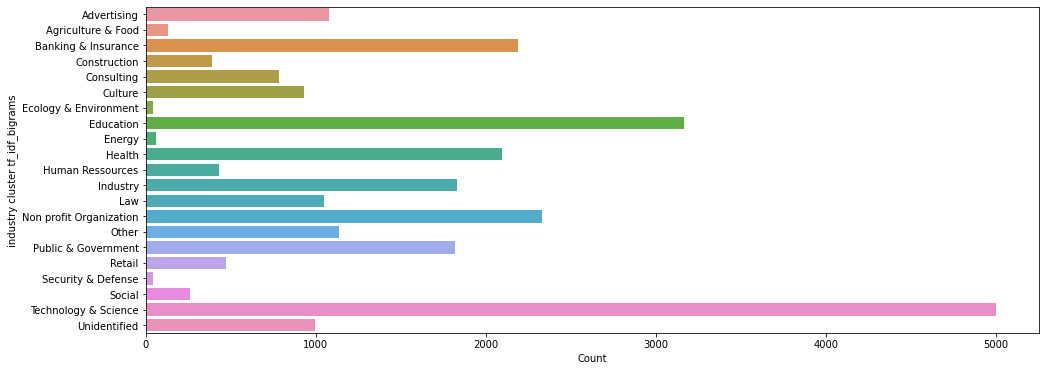

In [68]:
plt.figure(figsize=(16, 6))
sns.barplot(data=industries_cluster, y=industries_cluster.index, x="Count")

In [55]:
other = pd.DataFrame(df[df["industry cluster tf_idf_bigrams"]=="Other"]["industry"].value_counts())
other[other["industry"]>1].reset_index()["index"].unique()

array(['Prefer not to answer', 'Real Estate', 'Translation',
       'Philanthropy', 'Museum', 'Politics', 'Automotive',
       'Biotech/Pharma', 'Mining', 'Commercial Real Estate', 'Defense',
       'Museums', 'Childcare', 'Software', 'Cannabis', 'Librarian',
       'Food service', 'Restaurant', 'Academia', 'Archives', 'Fitness',
       'E-commerce', 'Training', 'Fundraising', 'Biopharma',
       'International development', 'Clergy', 'Journalism', 'Technology',
       'Food Service', 'Public Health', 'Trade Association', 'Aerospace',
       'Public health', 'Government contractor', 'IT', 'Scientist',
       'Finance', 'Labor Union', 'Compliance', 'Urban Planning',
       'Government Contracting', 'Biotech/pharmaceuticals',
       'Libraries and Archives', 'Ministry', 'Government Relations',
       'Food & Beverage', 'Human Resources', 'Customer Service',
       'Apparel', 'Warehouse', 'International Development',
       'Medical Devices', 'Fintech', 'wholesale distribution',
       'H

In [78]:
df.to_csv("../data/survey.csv")

In [9]:
matrix["industry_cluster"] = df["industry cluster tf_idf_bigrams"].copy()

In [10]:
matrix.to_csv("../data/vectorization.csv")